In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("drive/My Drive/COVID19_modelling")
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Covid19.ipynb  data  README.md


In [0]:
import pandas as pd
import numpy as np
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [0]:
# Default Font size for plt
size=25
# size=15
params = {'legend.fontsize': 'large',
          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}
plt.rcParams.update(params)

## Data Collection

The dataset I am going to use for this project is a kaggle dataset: https://www.kaggle.com/smid80/coronavirus-covid19-tweets

## Objective
I want to figure out what the top topics revolving covid19 are discussed on twitter in North America and for this, I will be looking at all the tweets related to Corona Virus on March 18 as this is the latest day covered in the kaggle dataset with a total of 626k tweets collected. 

## EDA 
Just want to look at a few graphs and insights on the data first

In [4]:
tweets_df = pd.read_csv("./data/2020-03-18 Coronavirus Tweets.CSV")
tweets_df.shape

(626206, 22)

In [5]:
tweets_df.head()

,status_id,user_id,created_at,screen_name,text,source,reply_to_status_id,reply_to_user_id,reply_to_screen_name,is_quote,is_retweet,favourites_count,retweet_count,country_code,place_full_name,place_type,followers_count,friends_count,account_lang,account_created_at,verified,lang
0,1240065379747000321,1034185124085157888,2020-03-18T00:00:00Z,Arconel_ec,#QuédateEnCasa | Recuerda que en el #EstadoDeE...,TweetDeck,NaN,NaN,NaN,False,False,5560,0,NaN,NaN,NaN,1383,162,NaN,2018-08-27T21:05:22Z,False,es
1,1240065380959346689,2533007966,2020-03-18T00:00:00Z,CelecEnerjubone,¡#QuédateEnCasa y respeta el #EstadoDeExcepció...,TweetDeck,NaN,NaN,NaN,False,False,18,0,NaN,NaN,NaN,1588,358,NaN,2014-05-29T16:53:45Z,False,es
2,1240065379428225024,44728980,2020-03-18T00:00:00Z,ANCALERTS,"With Broadway's lights dimmed, actors mull pan...",TweetDeck,NaN,NaN,NaN,False,False,5454,0,NaN,NaN,NaN,4851097,777,NaN,2009-06-04T21:26:24Z,True,en
3,1240065379918942210,15872418,2020-03-18T00:00:00Z,ABSCBNNews,Isa si Kevin Durant sa 4 players ng Brooklyn N...,TweetDeck,NaN,NaN,NaN,False,False,1070,256,NaN,NaN,NaN,6723816,1075,NaN,2008-08-16T10:09:33Z,True,tl
4,1240065379579441154,1185122746960941057,2020-03-18T00:00:00Z,DuvarEnglish,CORONAVIRUS UPDATES - A total of 19 people we...,TweetDeck,NaN,NaN,NaN,False,False,7,0,NaN,NaN,NaN,14291,1,NaN,2019-10-18T09:17:51Z,False,en


In [6]:
tweets_df.columns

Index(['status_id', 'user_id', 'created_at', 'screen_name', 'text', 'source',
       'reply_to_status_id', 'reply_to_user_id', 'reply_to_screen_name',
       'is_quote', 'is_retweet', 'favourites_count', 'retweet_count',
       'country_code', 'place_full_name', 'place_type', 'followers_count',
       'friends_count', 'account_lang', 'account_created_at', 'verified',
       'lang'],
      dtype='object')

In [7]:
countries_df = pd.read_csv("data/Countries.CSV", na_filter = False)
countries_df.columns = ['country', 'country_code']
countries_df['country_code'] = countries_df['country_code']
countries_df.loc[0, "country"] = float("nan")
countries_df.loc[0, "country_code"] = float("nan")
countries_df

,country,country_code
0,NaN,NaN
1,Afghanistan,AF
2,Albania,AL
3,Algeria,DZ
4,Andorra,AD
...,...,...
186,Vietnam,VN
187,"Virgin Islands, U.S.",VI
188,Yemen,YE
189,Zambia,ZM


In [8]:
tweets_df = pd.merge(tweets_df, countries_df, on='country_code')
tweets_df.head()

,status_id,user_id,created_at,screen_name,text,source,reply_to_status_id,reply_to_user_id,reply_to_screen_name,is_quote,is_retweet,favourites_count,retweet_count,country_code,place_full_name,place_type,followers_count,friends_count,account_lang,account_created_at,verified,lang,country
0,1240065379747000321,1034185124085157888,2020-03-18T00:00:00Z,Arconel_ec,#QuédateEnCasa | Recuerda que en el #EstadoDeE...,TweetDeck,NaN,NaN,NaN,False,False,5560,0,NaN,NaN,NaN,1383,162,NaN,2018-08-27T21:05:22Z,False,es,NaN
1,1240065380959346689,2533007966,2020-03-18T00:00:00Z,CelecEnerjubone,¡#QuédateEnCasa y respeta el #EstadoDeExcepció...,TweetDeck,NaN,NaN,NaN,False,False,18,0,NaN,NaN,NaN,1588,358,NaN,2014-05-29T16:53:45Z,False,es,NaN
2,1240065379428225024,44728980,2020-03-18T00:00:00Z,ANCALERTS,"With Broadway's lights dimmed, actors mull pan...",TweetDeck,NaN,NaN,NaN,False,False,5454,0,NaN,NaN,NaN,4851097,777,NaN,2009-06-04T21:26:24Z,True,en,NaN
3,1240065379918942210,15872418,2020-03-18T00:00:00Z,ABSCBNNews,Isa si Kevin Durant sa 4 players ng Brooklyn N...,TweetDeck,NaN,NaN,NaN,False,False,1070,256,NaN,NaN,NaN,6723816,1075,NaN,2008-08-16T10:09:33Z,True,tl,NaN
4,1240065379579441154,1185122746960941057,2020-03-18T00:00:00Z,DuvarEnglish,CORONAVIRUS UPDATES - A total of 19 people we...,TweetDeck,NaN,NaN,NaN,False,False,7,0,NaN,NaN,NaN,14291,1,NaN,2019-10-18T09:17:51Z,False,en,NaN


In [9]:
len(tweets_df.country_code.unique())

179

## Bar graph for tweets based on language

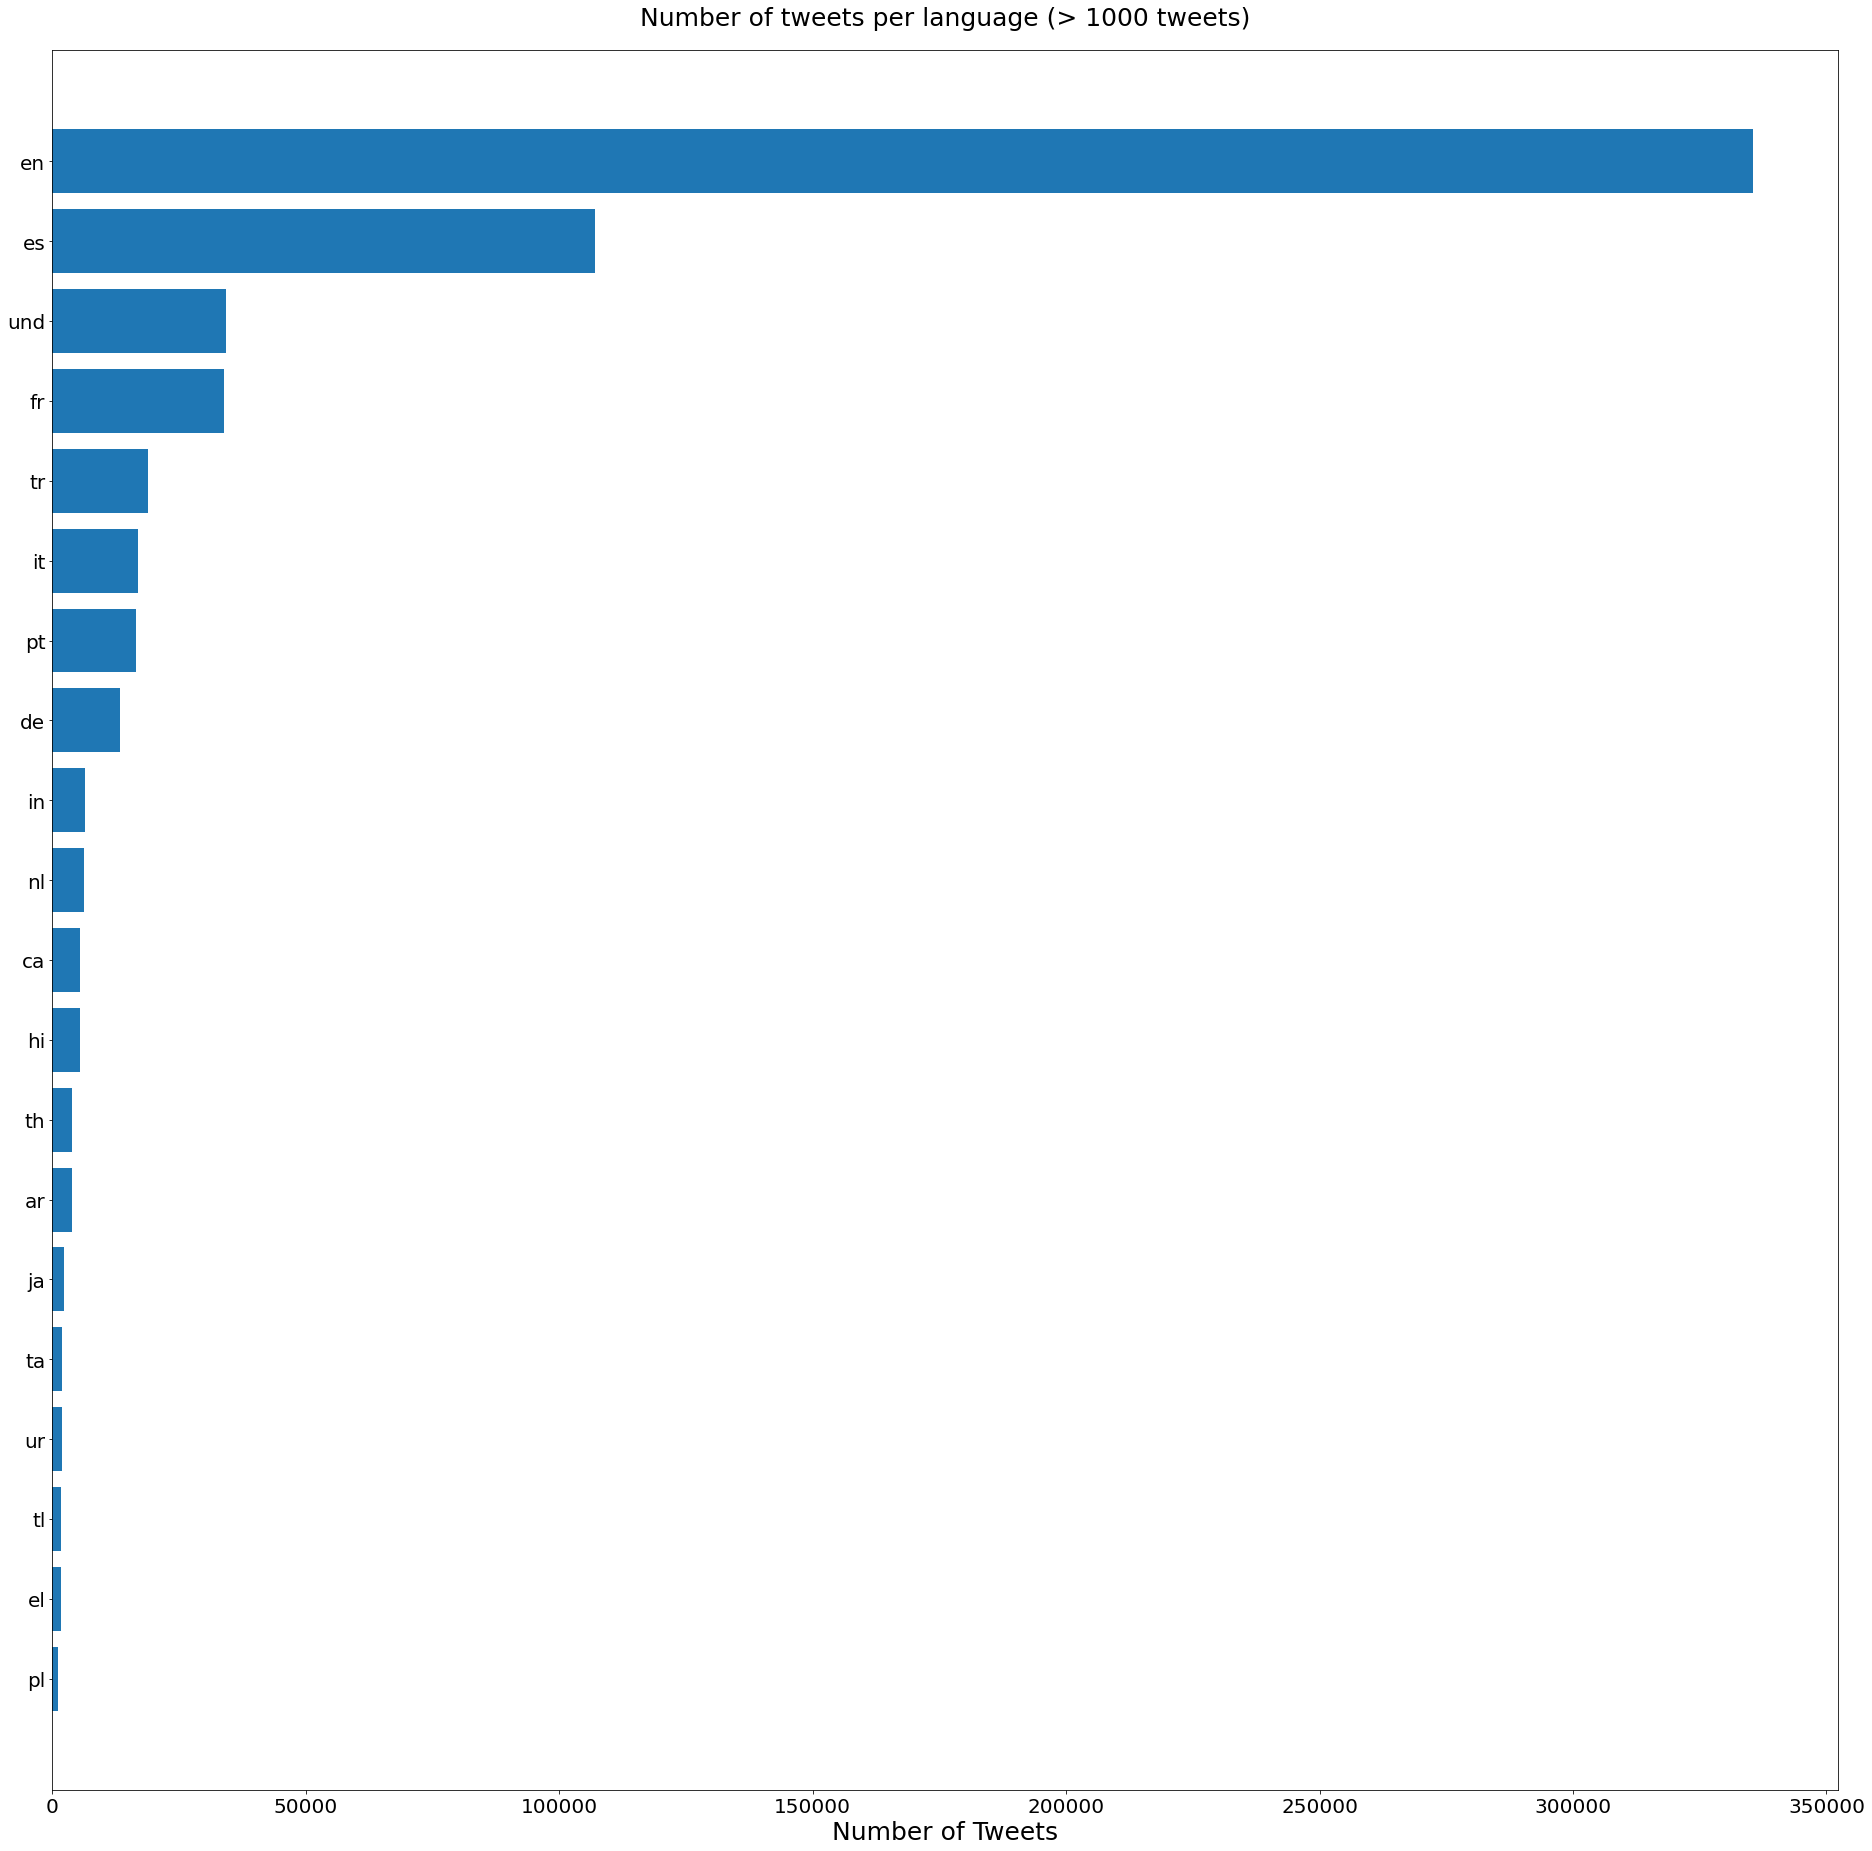

In [10]:
## Group by language
# fig, ax = plt.subplots(figsize=(15,7))
lang_tweets = tweets_df.groupby('lang', as_index=False).count()[['lang','status_id']].sort_values(by=['status_id'])
lang_tweets = lang_tweets[lang_tweets['status_id'] > 1000]
plt.figure(figsize=(32,32))
plt.barh(lang_tweets['lang'], lang_tweets['status_id'])
plt.title("Number of tweets per language (> 1000 tweets)")
plt.xlabel("Number of Tweets")
plt.tick_params(labelsize=20)
plt.show()

## Bar graph for tweets based on country

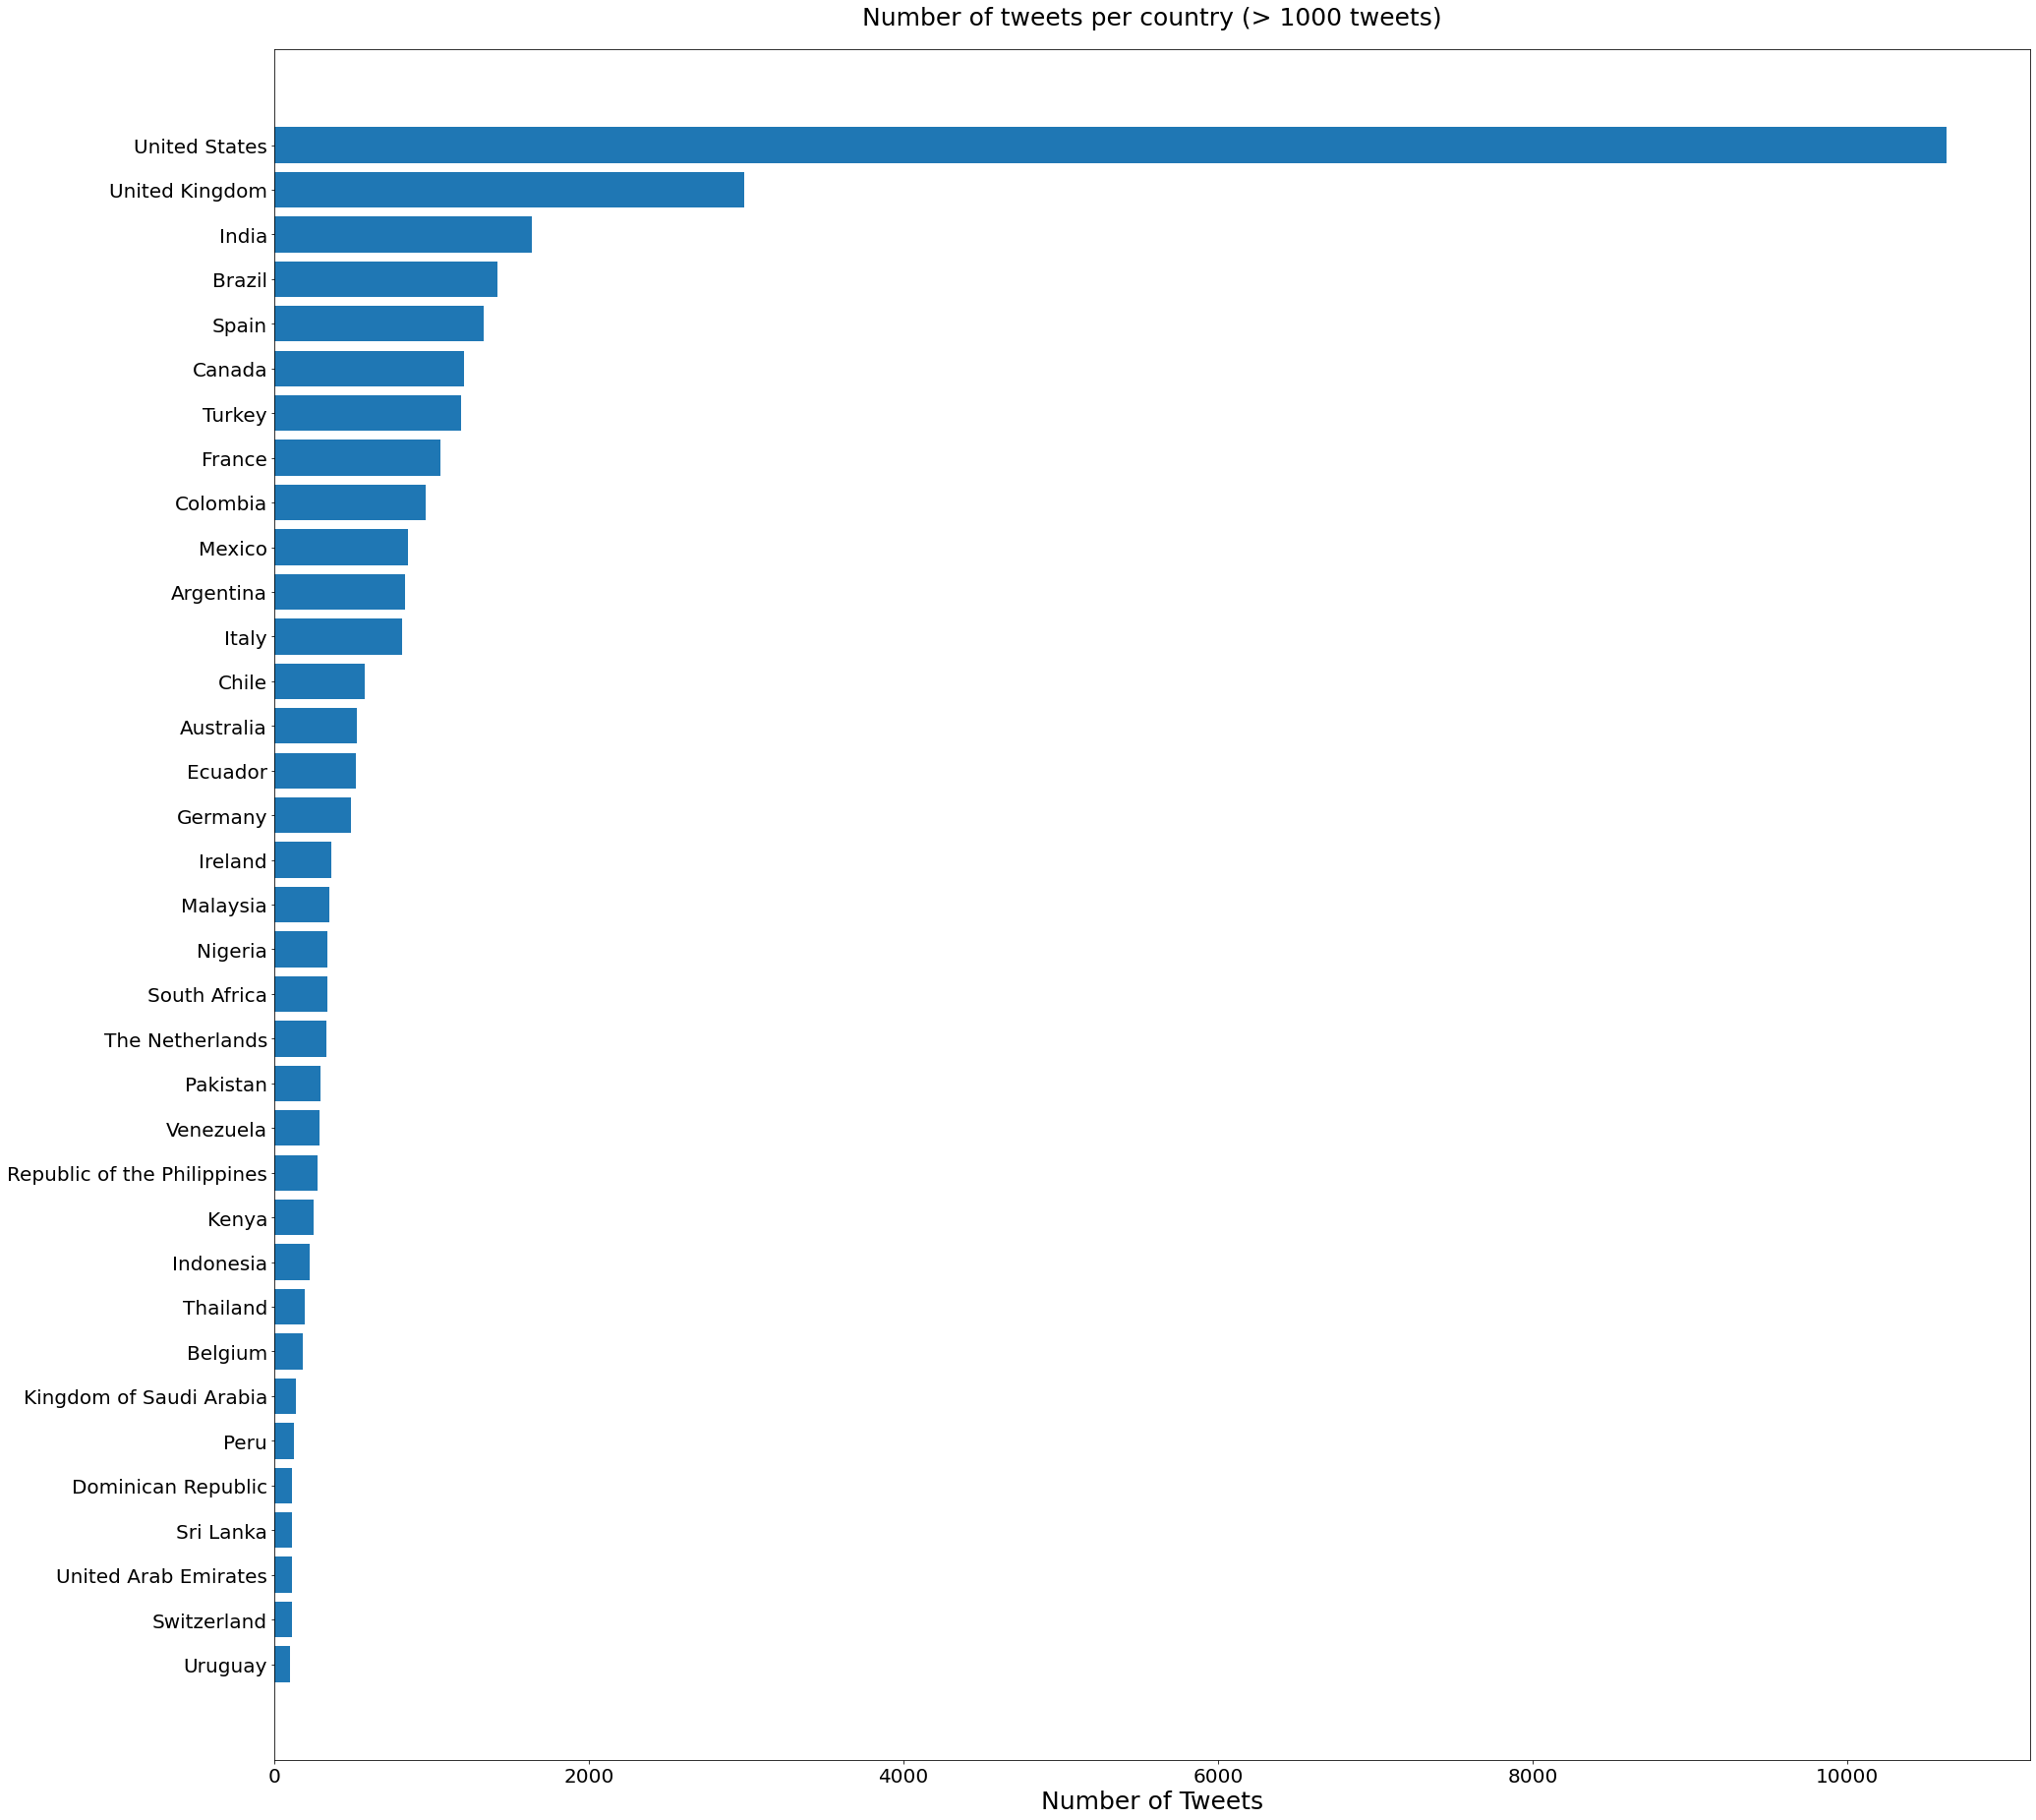

In [11]:
## Group by country
# fig, ax = plt.subplots(figsize=(15,7))
lang_tweets = tweets_df.groupby('country', as_index=False).count()[['country','status_id']].sort_values(by=['status_id'])
lang_tweets = lang_tweets[lang_tweets['status_id'] > 100]
plt.figure(figsize=(32,32))
plt.barh(lang_tweets['country'], lang_tweets['status_id'])
plt.title("Number of tweets per country (> 1000 tweets)")
plt.xlabel("Number of Tweets")
plt.tick_params(labelsize=20)
plt.show()

## Bar chart based on the medium used to tweet

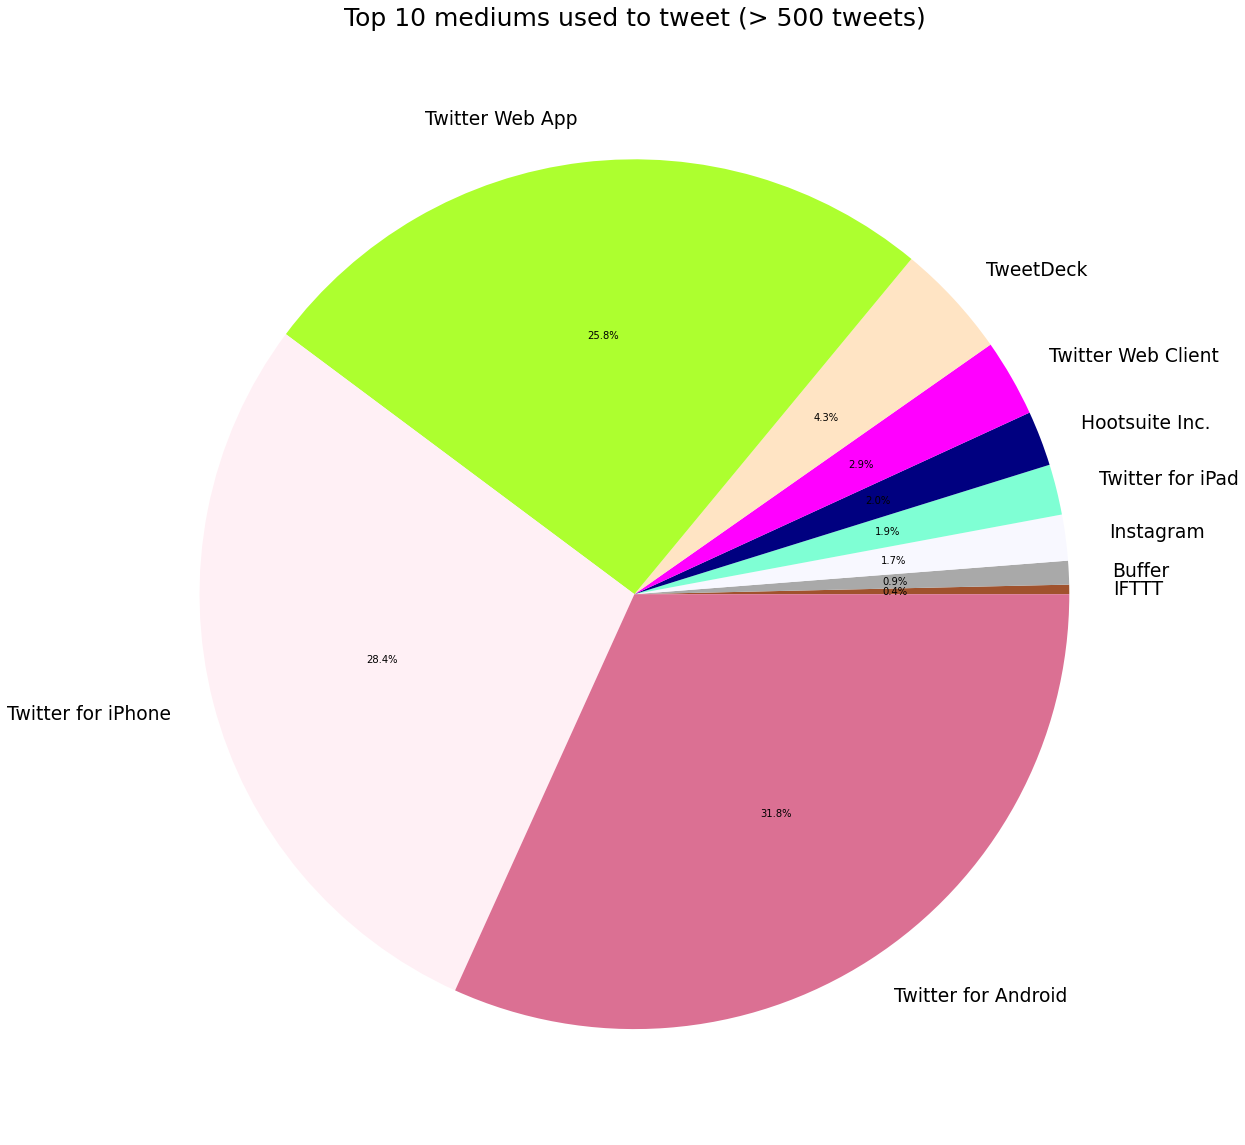

In [12]:
import random
import matplotlib.colors as mcolors

source_tweets = tweets_df.groupby('source', as_index=False).count()[['source','status_id']].sort_values(by=['status_id'])
source_tweets = source_tweets[source_tweets['status_id'] > 2000]
plt.figure(figsize=(20,20))
colors = random.choices(list(mcolors.CSS4_COLORS.values()), k = len(source_tweets))
plt.pie(source_tweets['status_id'], colors=colors, autopct='%1.1f%%', labels=source_tweets['source'])
# plt.legend(source_tweets['source'], loc="best")
plt.title("Top 10 mediums used to tweet (> 500 tweets)")
plt.show()

## Most Retweeted Tweets

In [13]:
fav_tweets = tweets_df[tweets_df['lang']=='en'].sort_values(by=['retweet_count'], ascending=False)[['screen_name','text','retweet_count','followers_count']]
fav_tweets.shape

(335511, 4)

## Data Cleaning
* Filter to only North American tweets
* Filter for english only tweets
* Make sure it's got some likes
* Clean the text

In [0]:
import string
import re
from nltk.corpus import stopwords 
from sklearn.feature_extraction.text import TfidfVectorizer

def clean_text(txt: str):
#     sw = set(stopwords.words('english')) 
    txt = "".join([c.lower() for c in txt if not c.isdigit()])
    txt = re.sub(r"http\S+", "", txt)
    # removes emojis
    txt = txt.encode('ascii', 'ignore').decode('ascii')
    txt = re.sub("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)"," ",txt)
    txt = re.sub("\n", ".", txt)
#     txt = " ".join([word for word in tokens])

    return txt

In [15]:
filtered_tweets_df = tweets_df[(tweets_df['lang'] == 'en') & (tweets_df['retweet_count'] > 5)]
filtered_tweets_df.shape

(19025, 23)

In [16]:
filtered_tweets_df.head()

,status_id,user_id,created_at,screen_name,text,source,reply_to_status_id,reply_to_user_id,reply_to_screen_name,is_quote,is_retweet,favourites_count,retweet_count,country_code,place_full_name,place_type,followers_count,friends_count,account_lang,account_created_at,verified,lang,country
33,1240065380791574529,38489678,2020-03-18T00:00:00Z,JAMA_current,In this case series of 138 patients hospitaliz...,Sprinklr,NaN,NaN,NaN,False,False,1307,274,NaN,NaN,NaN,339071,805,NaN,2009-05-07T18:45:39Z,True,en,NaN
37,1240065380409737217,115105973,2020-03-18T00:00:00Z,SylvesterTurner,"This past weekend, many faith base services we...",TweetDeck,NaN,NaN,NaN,False,False,7490,7,NaN,NaN,NaN,99975,1693,NaN,2010-02-17T16:39:53Z,True,en,NaN
89,1240065381592526849,1652541,2020-03-18T00:00:00Z,Reuters,U.S. technology companies say they are working...,Twitter Media Studio,NaN,NaN,NaN,False,False,750,44,NaN,NaN,NaN,21430677,1114,NaN,2007-03-20T17:46:05Z,True,en,NaN
101,1240065381630279680,37034483,2020-03-18T00:00:00Z,ndtv,Indian Railways cancels 76 trains amid #corona...,TweetDeck,NaN,NaN,NaN,False,False,0,11,NaN,NaN,NaN,12238680,14,NaN,2009-05-01T20:34:48Z,True,en,NaN
106,1240065381059837952,64643056,2020-03-18T00:00:00Z,RT_com,No more free borders\n\nNon-essential travel i...,Twitter Media Studio,NaN,NaN,NaN,False,False,943,44,NaN,NaN,NaN,3070382,638,NaN,2009-08-11T06:12:45Z,True,en,NaN


In [17]:
filtered_tweets_df['clean_text'] = filtered_tweets_df['text'].apply(lambda t: clean_text(t))
pd.options.display.max_colwidth = 1000
filtered_tweets_df[['text', 'clean_text']].head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,text,clean_text
33,In this case series of 138 patients hospitalized w #COVID19 #pneumonia\n- 38 (26%) required ICU admission\n- 6 (4.3%) died\n- 57 (41.3%) were presumed to have been infected in the hospital including \n-- 17 (12.3%) already hospitalized \n-- 40 (29%) HCWs https://t.co/vlwa3M5X8F,in this case series of patients hospitalized w .- (%) required icu admission.- (.%) died.- (.%) were presumed to have been infected in the hospital including .-- (.%) already hospitalized .-- (%) hcws
37,"This past weekend, many faith base services were held in moderation or moved online. On a call last week, I encouraged our churches to engage in social distancing and more.\n\nThis @HoustonChron article explains how some churches are navigating #COVID19. \n\nhttps://t.co/5en7VIitxy","this past weekend, many faith base services were held in moderation or moved online. on a call last week, i encouraged our churches to engage in social distancing and more...this article explains how some churches are navigating . .."
89,U.S. technology companies say they are working in coordination with government healthcare agencies around the world to share critical updates about the #coronavirus https://t.co/bTQGiCscxW https://t.co/KTIH5mDJNX,u.s. technology companies say they are working in coordination with government healthcare agencies around the world to share critical updates about the
101,Indian Railways cancels 76 trains amid #coronavirus scare. https://t.co/927DVUxDAB https://t.co/QMPGnasERw,indian railways cancels trains amid scare.
106,No more free borders\n\nNon-essential travel in EU restricted for 30 days\n\n#coronavirus\n\nMORE: https://t.co/kAkYTauiQ2 https://t.co/UeVPBv32eV,no more free borders..non-essential travel in eu restricted for days.. ..more:


## Sentence Embedding using BERT

In [18]:
import torch
!pip install flair
from flair.embeddings import BertEmbeddings, Sentence, DocumentPoolEmbeddings

In [19]:
bert_embedding = BertEmbeddings('bert-base-uncased')
document_embeddings = DocumentPoolEmbeddings([bert_embedding])
tweet_embeddings = torch.empty(size=(filtered_tweets_df.shape[0],3072)).cuda()

from tqdm import tqdm
for idx, text in enumerate(tqdm(filtered_tweets_df['clean_text'])):
  sentence = Sentence(text)
  document_embeddings.embed(sentence)
  tweet_embeddings[idx] = sentence.get_embedding()

100%|██████████| 19025/19025 [05:51<00:00, 54.06it/s]


In [0]:
from sklearn.decomposition import PCA

tweet_embeddings = tweet_embeddings.cpu().detach().numpy()
pca = PCA(n_components=500)
tweet_emb_reduces = pca.fit_transform(tweet_embeddings)

In [21]:
from sklearn.cluster import AgglomerativeClustering

N_CLUSTERS = 10

cluster = AgglomerativeClustering(n_clusters=N_CLUSTERS, affinity='euclidean', linkage='ward')
pred_cluster = cluster.fit_predict(tweet_emb_reduces)
filtered_tweets_df['topic'] = pred_cluster

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [22]:
filtered_tweets_df.head()

,status_id,user_id,created_at,screen_name,text,source,reply_to_status_id,reply_to_user_id,reply_to_screen_name,is_quote,is_retweet,favourites_count,retweet_count,country_code,place_full_name,place_type,followers_count,friends_count,account_lang,account_created_at,verified,lang,country,clean_text,topic
33,1240065380791574529,38489678,2020-03-18T00:00:00Z,JAMA_current,In this case series of 138 patients hospitalized w #COVID19 #pneumonia\n- 38 (26%) required ICU admission\n- 6 (4.3%) died\n- 57 (41.3%) were presumed to have been infected in the hospital including \n-- 17 (12.3%) already hospitalized \n-- 40 (29%) HCWs https://t.co/vlwa3M5X8F,Sprinklr,NaN,NaN,NaN,False,False,1307,274,NaN,NaN,NaN,339071,805,NaN,2009-05-07T18:45:39Z,True,en,NaN,in this case series of patients hospitalized w .- (%) required icu admission.- (.%) died.- (.%) were presumed to have been infected in the hospital including .-- (.%) already hospitalized .-- (%) hcws,0
37,1240065380409737217,115105973,2020-03-18T00:00:00Z,SylvesterTurner,"This past weekend, many faith base services were held in moderation or moved online. On a call last week, I encouraged our churches to engage in social distancing and more.\n\nThis @HoustonChron article explains how some churches are navigating #COVID19. \n\nhttps://t.co/5en7VIitxy",TweetDeck,NaN,NaN,NaN,False,False,7490,7,NaN,NaN,NaN,99975,1693,NaN,2010-02-17T16:39:53Z,True,en,NaN,"this past weekend, many faith base services were held in moderation or moved online. on a call last week, i encouraged our churches to engage in social distancing and more...this article explains how some churches are navigating . ..",5
89,1240065381592526849,1652541,2020-03-18T00:00:00Z,Reuters,U.S. technology companies say they are working in coordination with government healthcare agencies around the world to share critical updates about the #coronavirus https://t.co/bTQGiCscxW https://t.co/KTIH5mDJNX,Twitter Media Studio,NaN,NaN,NaN,False,False,750,44,NaN,NaN,NaN,21430677,1114,NaN,2007-03-20T17:46:05Z,True,en,NaN,u.s. technology companies say they are working in coordination with government healthcare agencies around the world to share critical updates about the,4
101,1240065381630279680,37034483,2020-03-18T00:00:00Z,ndtv,Indian Railways cancels 76 trains amid #coronavirus scare. https://t.co/927DVUxDAB https://t.co/QMPGnasERw,TweetDeck,NaN,NaN,NaN,False,False,0,11,NaN,NaN,NaN,12238680,14,NaN,2009-05-01T20:34:48Z,True,en,NaN,indian railways cancels trains amid scare.,2
106,1240065381059837952,64643056,2020-03-18T00:00:00Z,RT_com,No more free borders\n\nNon-essential travel in EU restricted for 30 days\n\n#coronavirus\n\nMORE: https://t.co/kAkYTauiQ2 https://t.co/UeVPBv32eV,Twitter Media Studio,NaN,NaN,NaN,False,False,943,44,NaN,NaN,NaN,3070382,638,NaN,2009-08-11T06:12:45Z,True,en,NaN,no more free borders..non-essential travel in eu restricted for days.. ..more:,3


## Distribution of tweets per topic

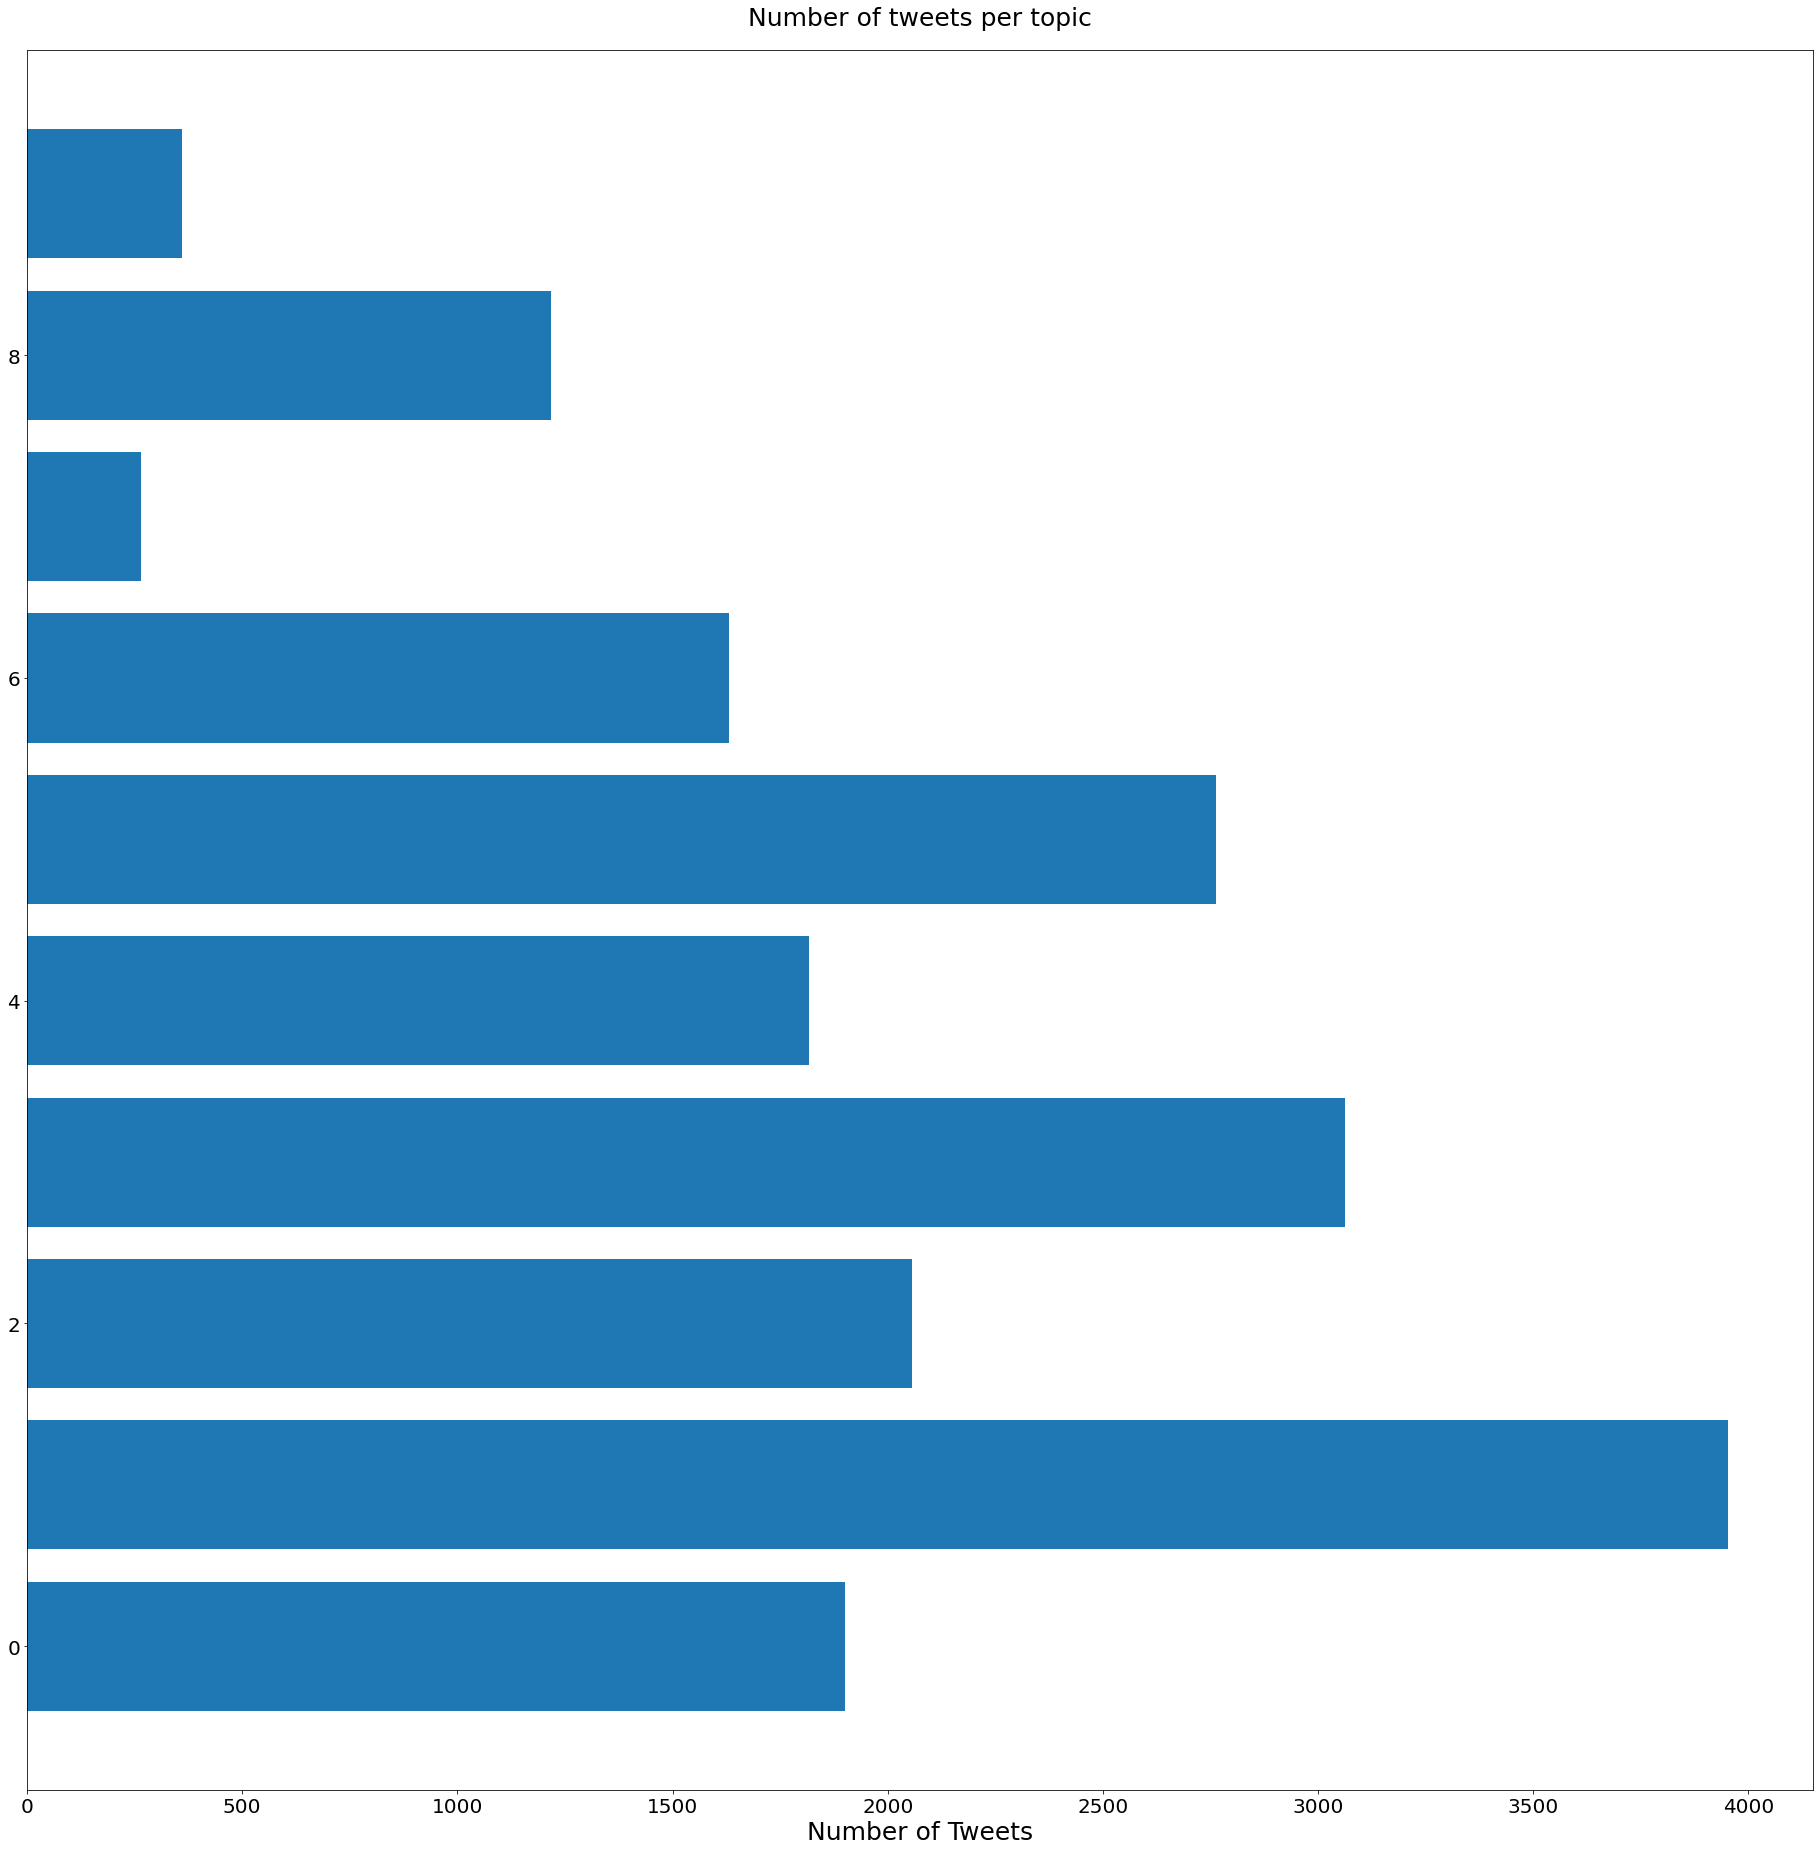

In [23]:
topic_tweets = filtered_tweets_df.groupby('topic', as_index=False).count()[['topic','status_id']].sort_values(by=['status_id'])
# topic_tweets = topic_tweets[topic_tweets['status_id'] > 100]
plt.figure(figsize=(32,32))
plt.barh(topic_tweets['topic'], topic_tweets['status_id'])
plt.title("Number of tweets per topic")
plt.xlabel("Number of Tweets")
plt.tick_params(labelsize=20)
plt.show()

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

topic_text = []
for topic in range(N_CLUSTERS):
  topic_text.append(' '.join(filtered_tweets_df[filtered_tweets_df['topic']==topic]['clean_text'].values))

len(topic_text)

10

In [0]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_df=0.5)
tfidf_matrix = vectorizer.fit_transform(topic_text)
features = vectorizer.get_feature_names()
tweet_df_tfidf = pd.DataFrame()
for doc in range(len(topic_text)):
  words = []
  scores = []
  feature_index = tfidf_matrix[doc,:].nonzero()[1]
  tfidf_scores = zip(feature_index, [tfidf_matrix[doc, x] for x in feature_index])
  for w, s in [(features[i], s) for (i, s) in tfidf_scores]:
    words.append(w)
    scores.append(s)
  df_temp = pd.DataFrame(data={'word':words, 'score': scores})
  df_temp = df_temp.sort_values('score',ascending=False).head(N_CLUSTERS)
  df_temp['topic'] = doc
  tweet_df_tfidf = tweet_df_tfidf.append(df_temp)


In [26]:
tweet_df_tfidf.head()

,word,score,topic
23757,new deaths,0.146511,0
22635,total number,0.128509,0
26677,recovered,0.121941,0
22302,reports new,0.104262,0
22983,air for,0.096635,0


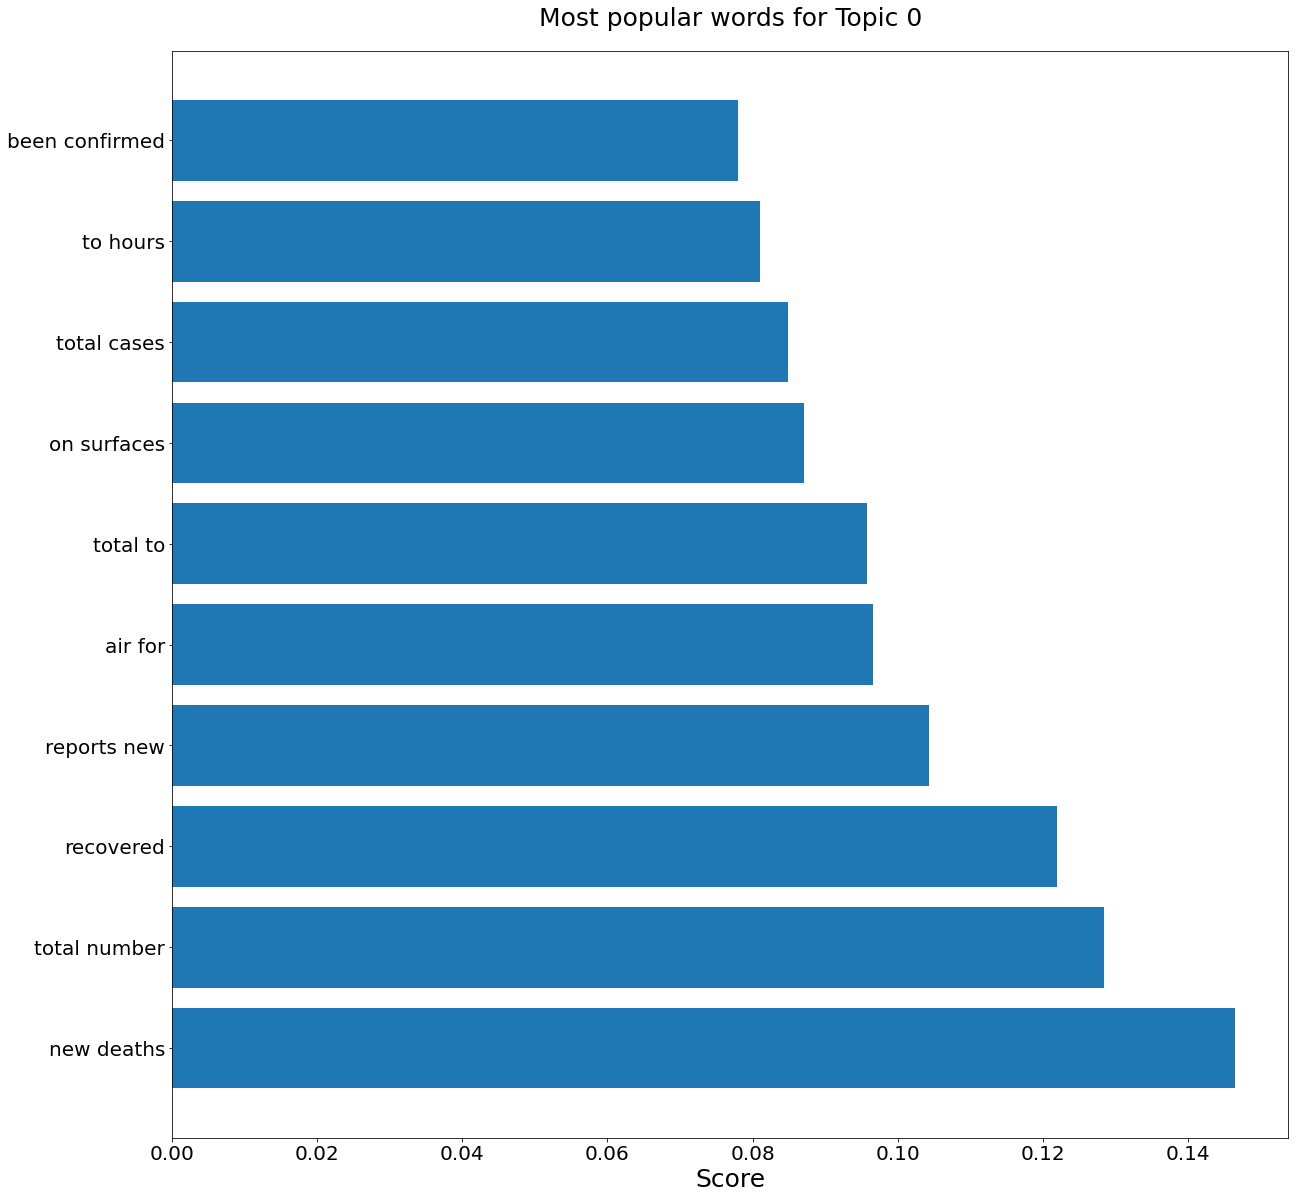

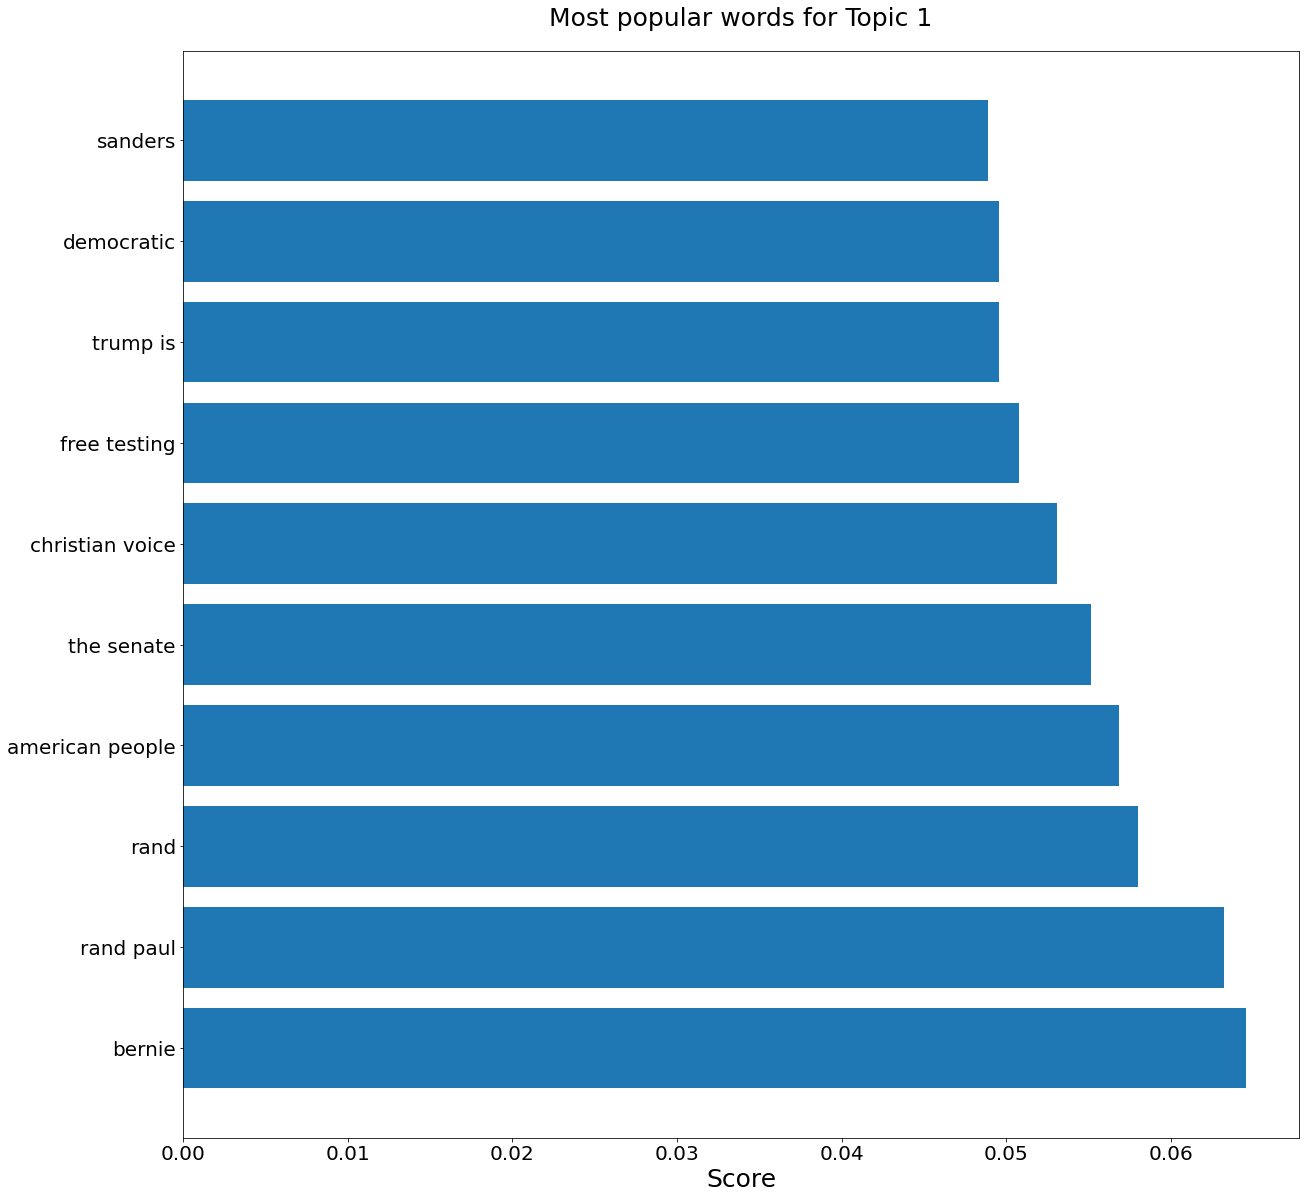

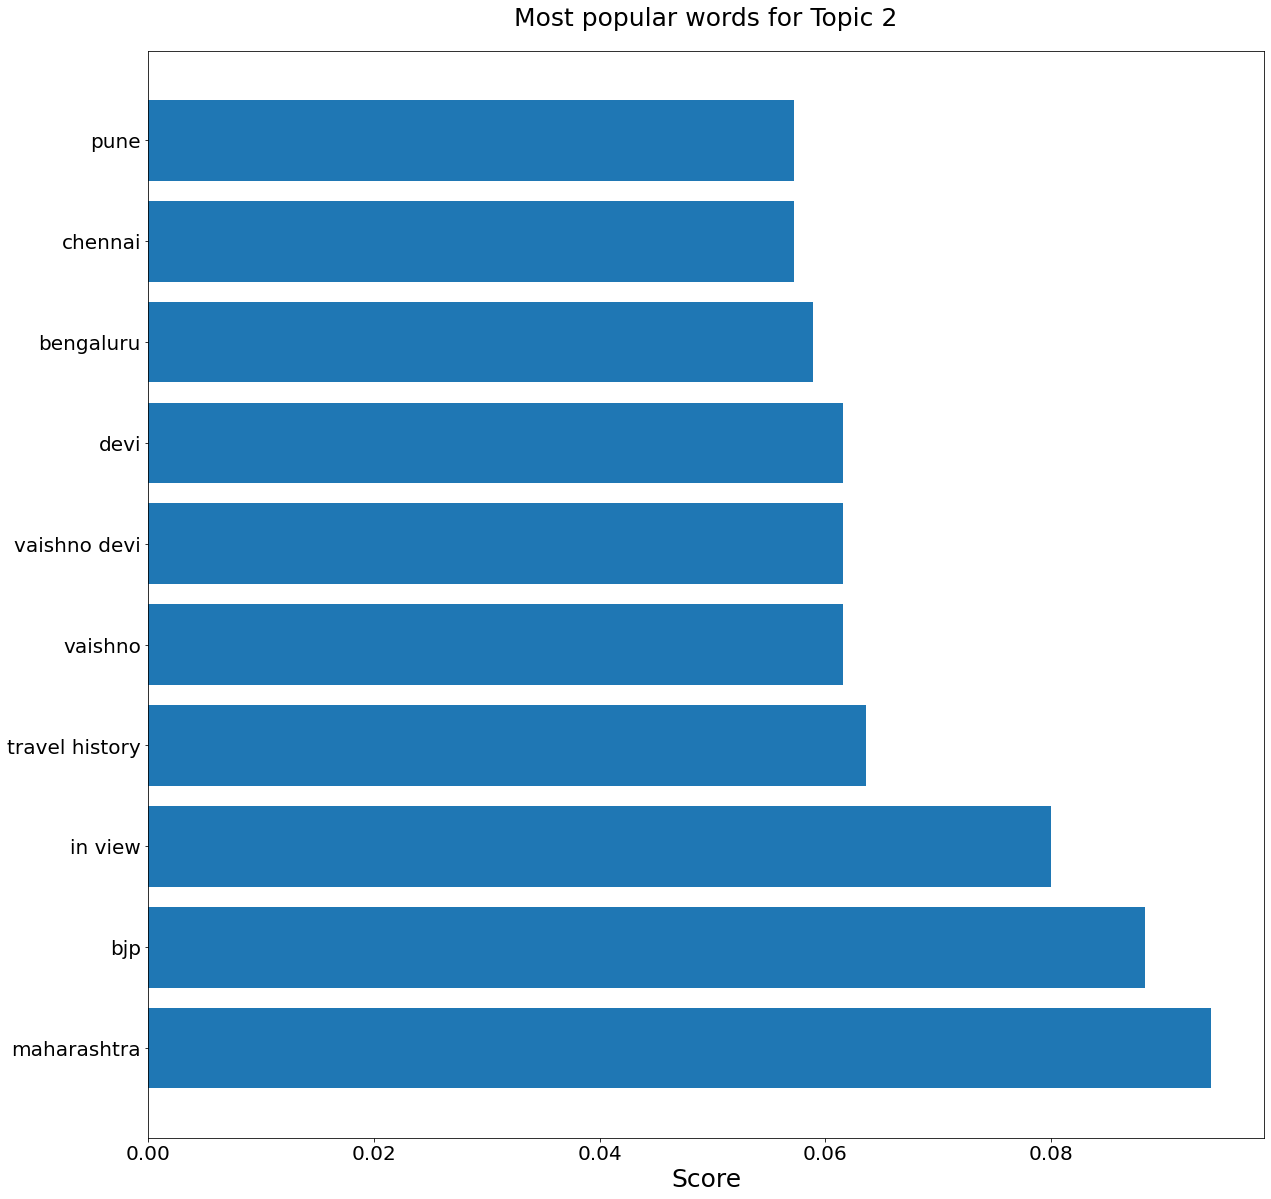

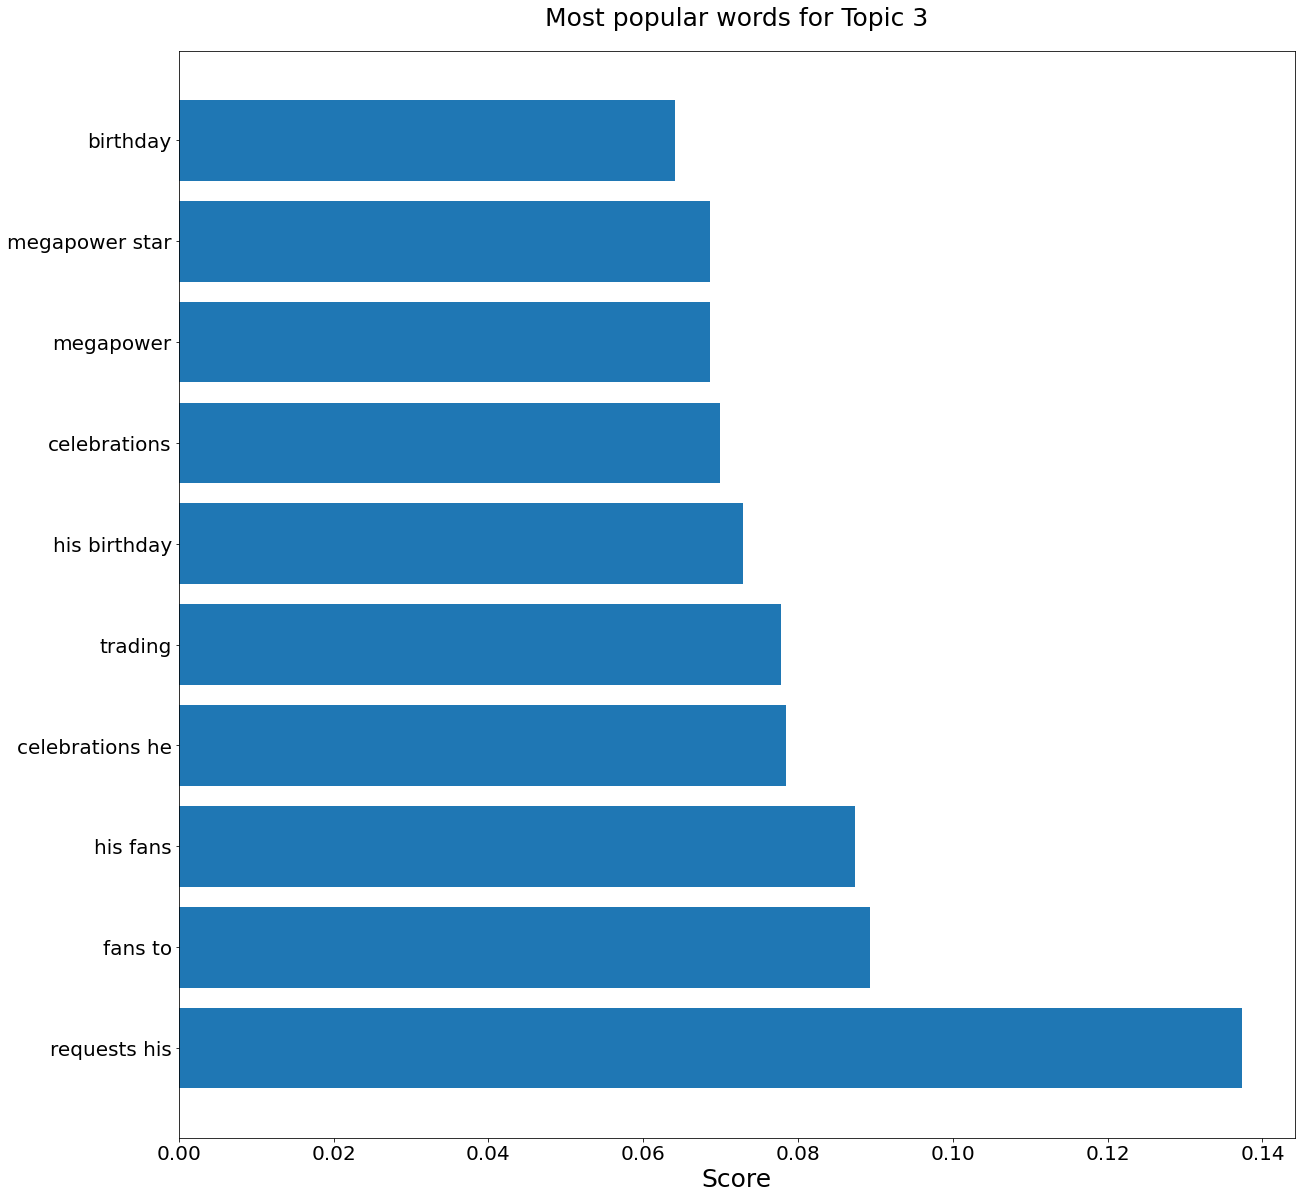

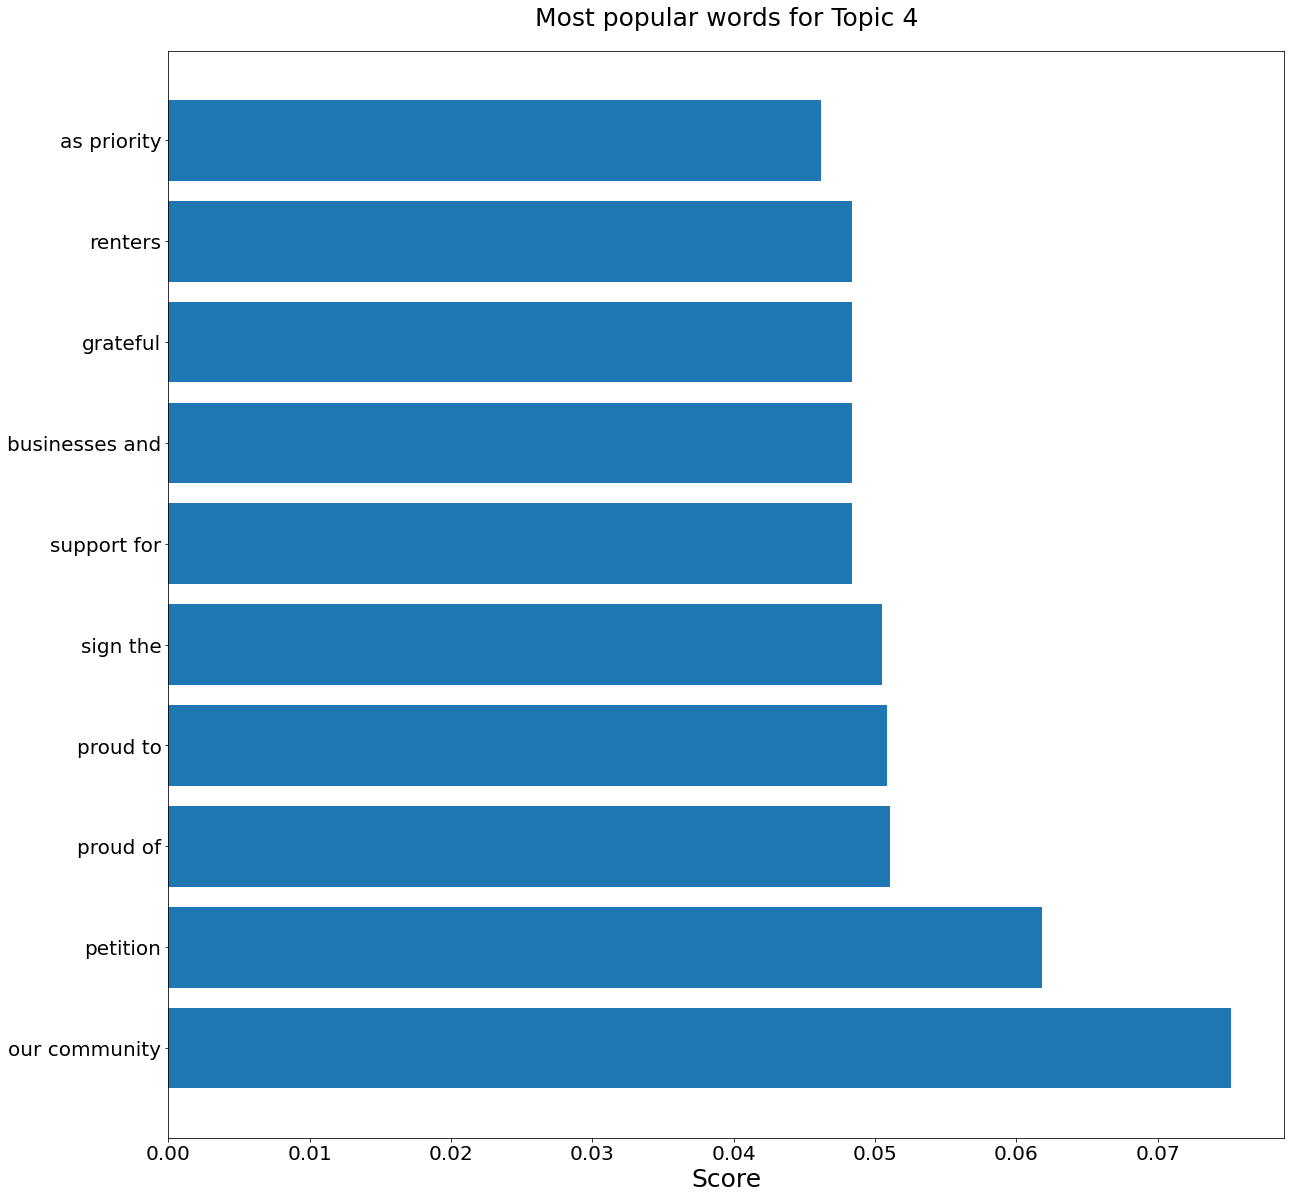

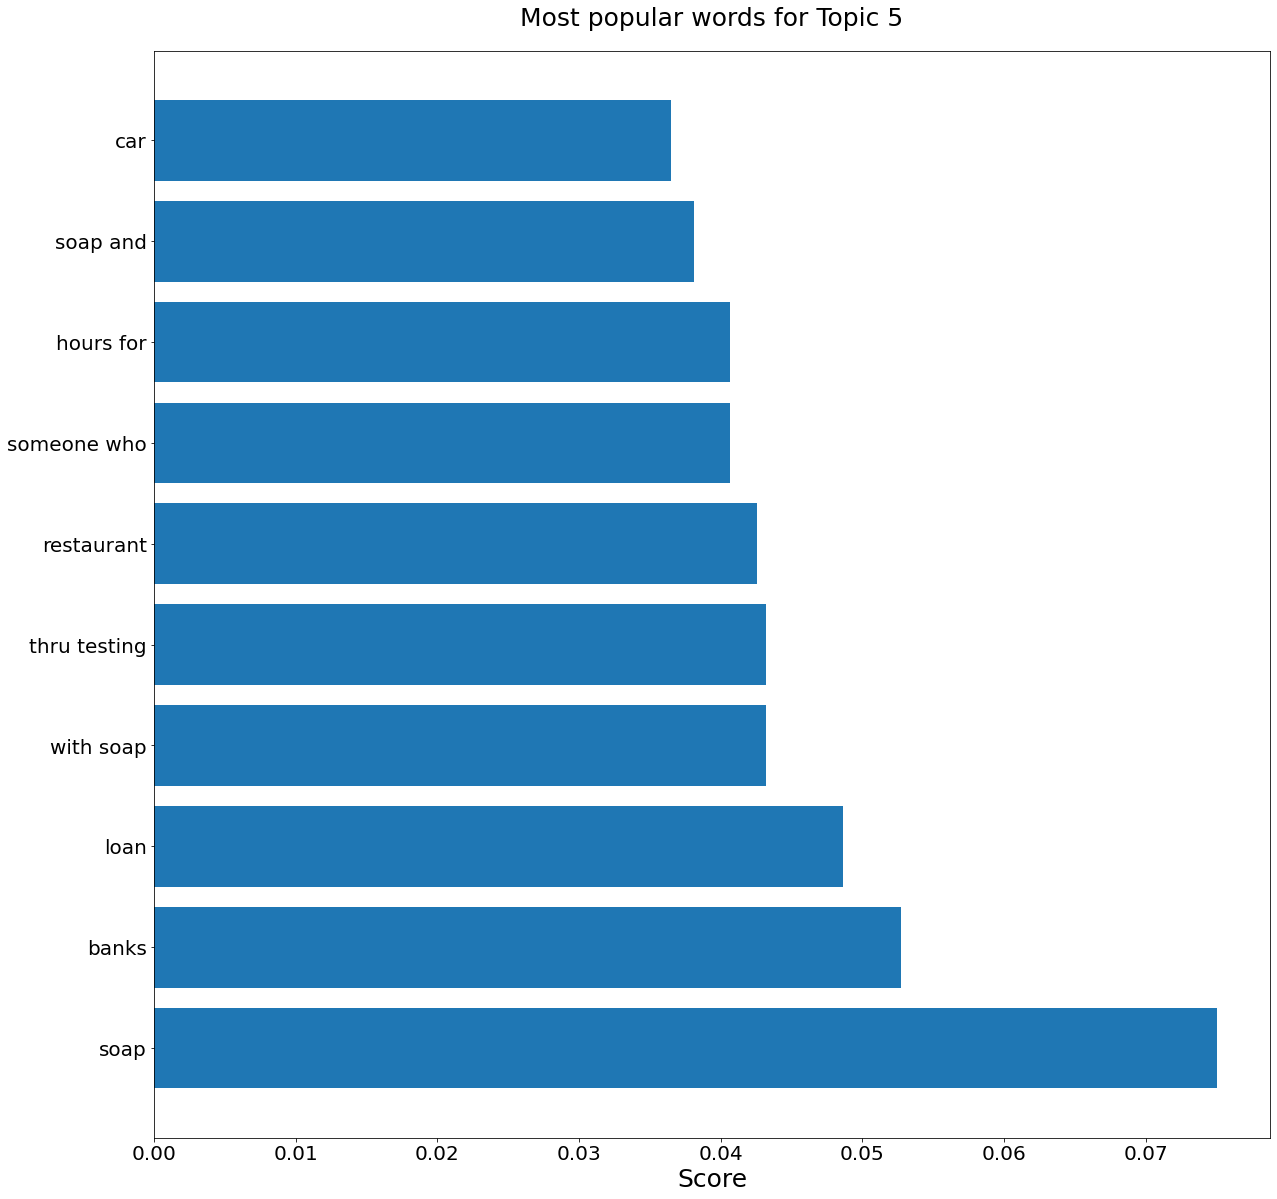

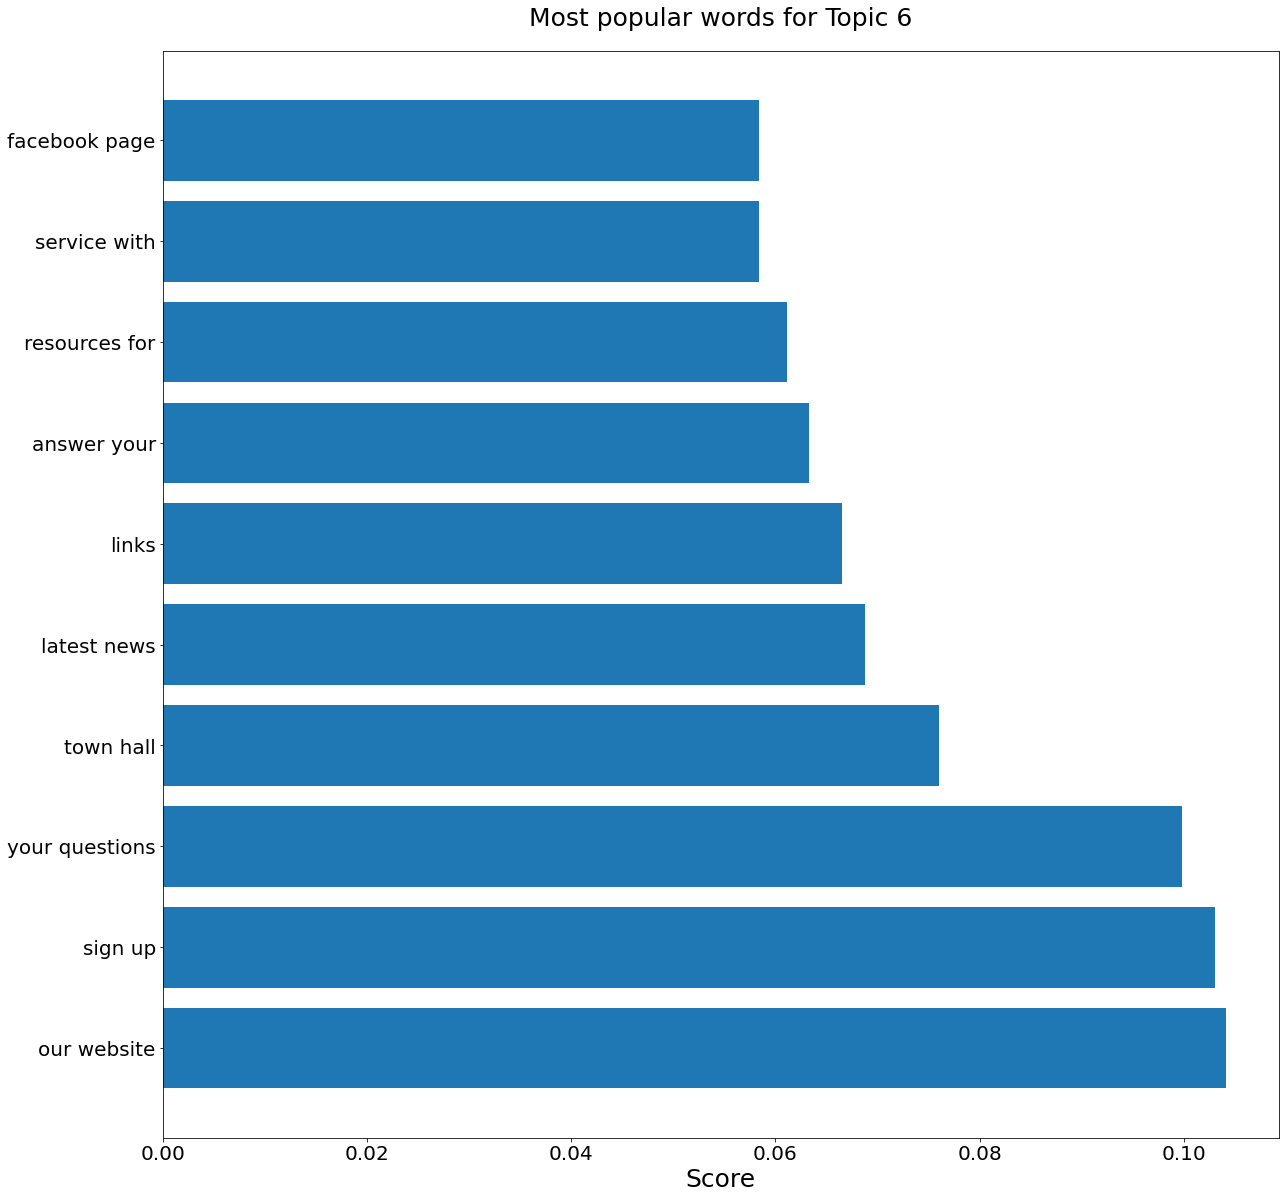

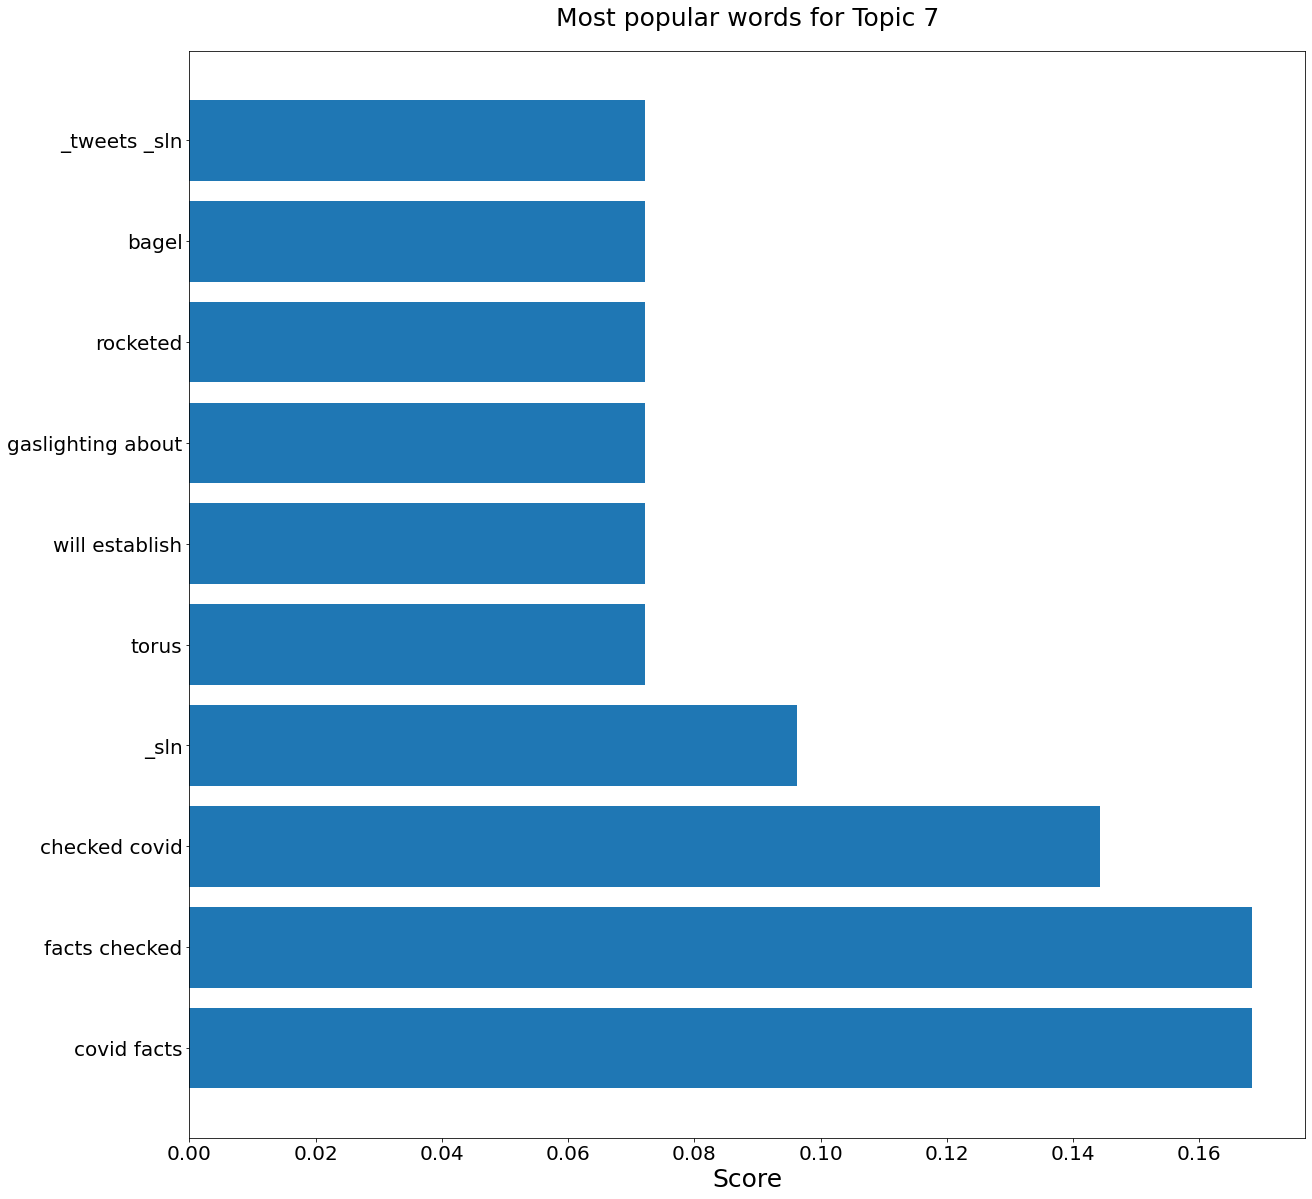

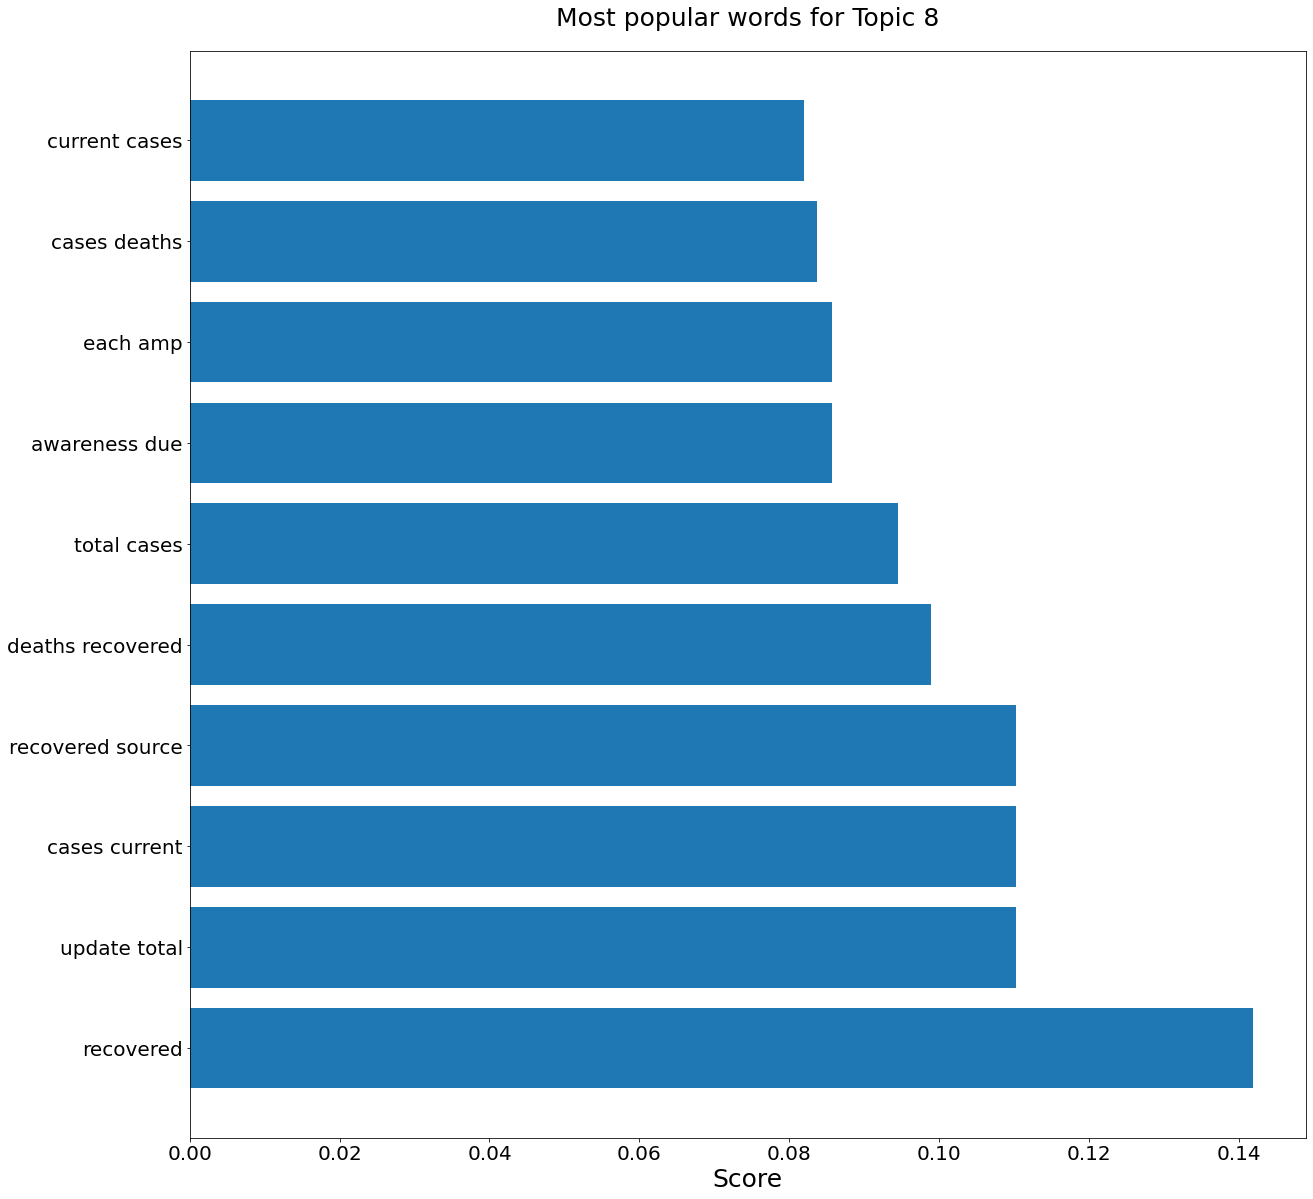

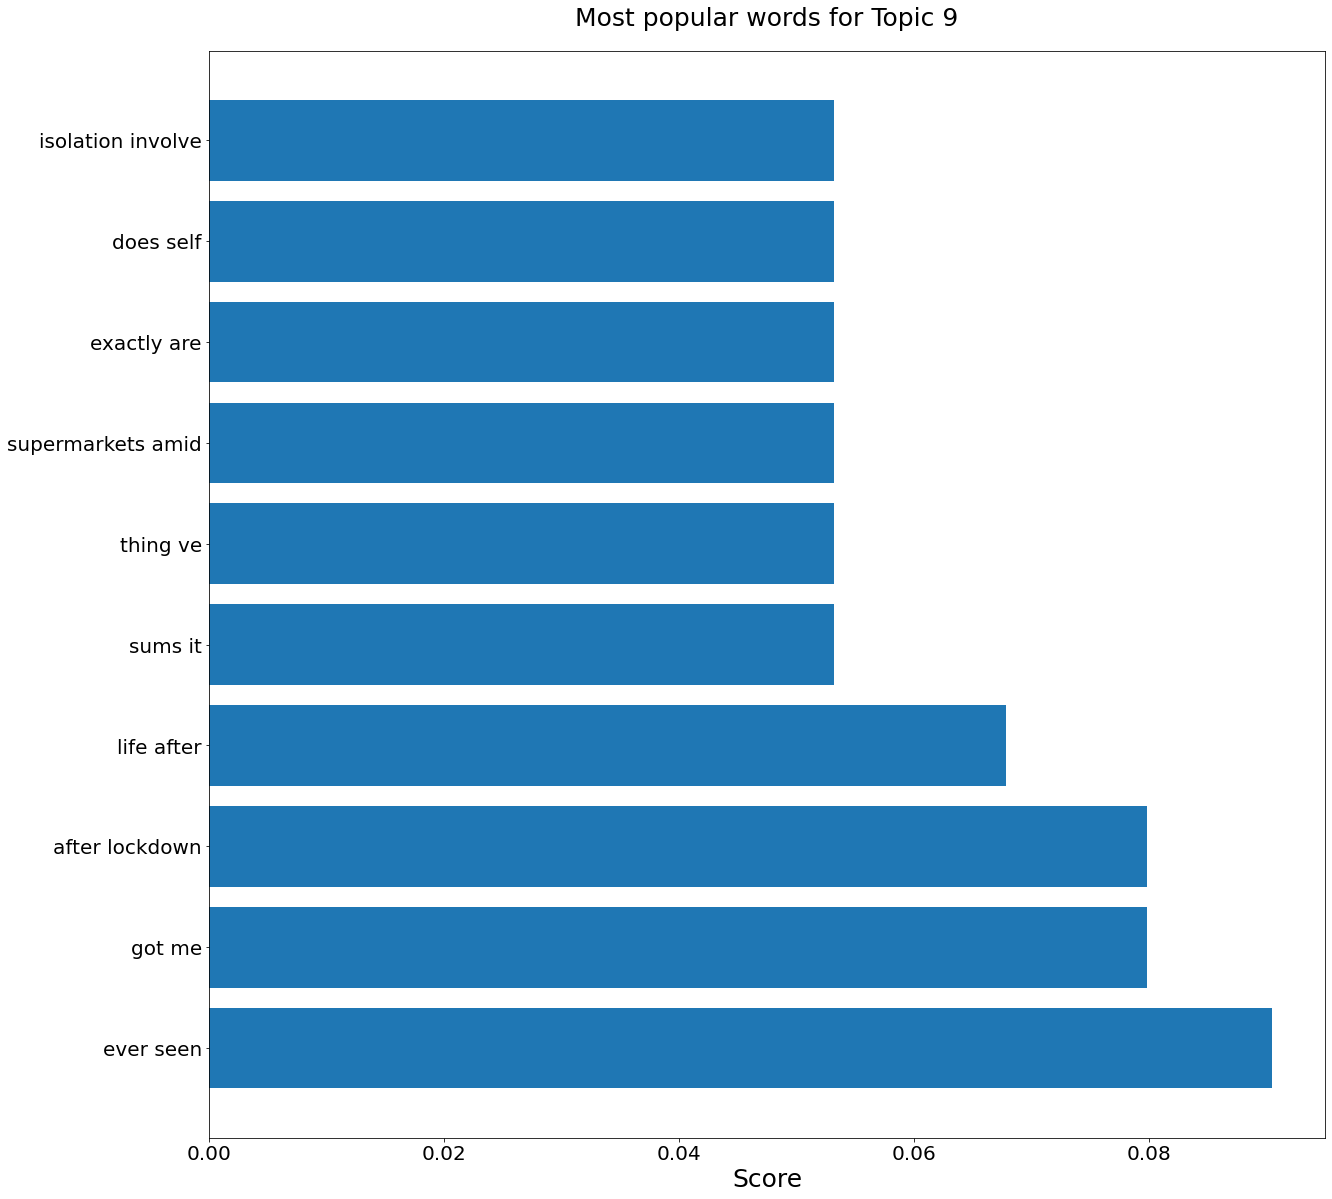

In [27]:
df_by_topic = tweet_df_tfidf.groupby(by='topic')
for name, g_df in df_by_topic:
  plt.figure(figsize=(20,20))
  plt.barh(g_df['word'], g_df['score'])
  plt.title(f'Most popular words for Topic {name}')
  plt.xlabel("Score")
  plt.tick_params(labelsize=20)
  plt.show()